# Setup

In [ ]:
import sys
import pandas as pd
from google.colab import drive
import numpy as np
import seaborn as sns
import re
import copy
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, f1_score, \
  precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

drive.mount("/content/drive")
data_path = "/content/drive/MyDrive/data/final_project/"
sys.path.insert(0,"/content/drive/MyDrive/data/final_project")
from twilio_creds import *


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install twilio

from twilio.rest import Client

client = Client(acct_sid, auth_token)

def send_text(message, client=client, to_phone=to_phone, from_phone=from_phone):
    client.messages.create(to=to_phone,
                           from_=from_phone,
                           body=message)

In [ ]:
def disp(df, n=5):
  print(df.shape)
  display(df.head(n))

# Data Prep

In [ ]:
questions = pd.read_csv(f"{data_path}Questions.csv", header=0, 
                        encoding="ISO-8859-1", engine="python", 
                        error_bad_lines=False)
# questions = pd.read_csv("Questions.csv", header=0, encoding="ISO-8859-1", 
#                         engine="python", error_bad_lines=False)
cols = {"Id": "id", "Title": "title", "Body": "body"}
questions = questions[cols.keys()].rename(columns=cols)

disp(questions)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


(1264216, 3)


,id,title,body
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
tags_long = pd.read_csv(f"{data_path}Tags.csv", header=0, encoding="ISO-8859-1",
                        engine="python", error_bad_lines=False)
# num_tags = 50
# top_tags = tags_long["Tag"].value_counts().head(num_tags).index
valid_tags = ["javascript", "java", "c#", "php", "python", "html", "c++", "sql", "c", "r"]
tags_long = tags_long[tags_long["Tag"].isin(valid_tags)]

tags = tags_long.groupby("Id").agg(tuple).applymap(list).reset_index()
tags = tags.rename(columns={"Id": "id", "Tag": "tag"})
tags = tags[tags["tag"].str.len() == 1]
tags["tag"] = tags["tag"].apply(lambda x: x[0])

disp(tags)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


(569098, 2)


,id,tag
0,120,sql
1,260,c#
2,330,c++
3,650,c#
4,930,c#


In [ ]:
tags_long["Tag"].value_counts()

javascript    124155
java          115212
c#            101186
php            98808
python         64601
html           58976
c++            47591
sql            35782
c              23238
r              15701
Name: Tag, dtype: int64

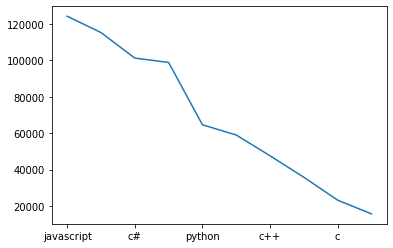

In [ ]:
tags_long["Tag"].value_counts().plot()

In [ ]:
df = questions.merge(tags, how="inner", on="id")
df = df.groupby("tag").sample(n=15000, random_state=314).reset_index(drop=True)

del questions, tags_long, tags

disp(df)

(150000, 4)


,id,title,body,tag
0,25600370,Data Validation in C when the user inputs an i...,<p>How do I ensure that the user inputs only a...,c
1,35082100,c malloc functionality for custom memory region,<p>Is there any malloc/realloc/free like imple...,c
2,18968070,Error when defining a stringising macro with _...,<p>I have been trying to implement a function ...,c
3,24130610,"Valgrind ""Conditional jump or move depends on ...",<p>I'm very new to C programming (my first que...,c
4,26009570,What improvements does GCC's `__builtin_malloc...,<p>I have recently been made aware of GCC's bu...,c


In [ ]:
# for i in range(5):
#   print(f"\n\n----TITLE {i}")
#   print(df["title"].iloc[i])

#   print(f"\n----BODY {i}")
#   print(df["body_proc"].iloc[i])

#   print(f"\n----TAGS {i}")
#   print(df["tag"].iloc[i])

# Preprocessing

In [ ]:
disp(df)

(150000, 4)


,id,title,body,tag
0,25600370,Data Validation in C when the user inputs an i...,<p>How do I ensure that the user inputs only a...,c
1,35082100,c malloc functionality for custom memory region,<p>Is there any malloc/realloc/free like imple...,c
2,18968070,Error when defining a stringising macro with _...,<p>I have been trying to implement a function ...,c
3,24130610,"Valgrind ""Conditional jump or move depends on ...",<p>I'm very new to C programming (my first que...,c
4,26009570,What improvements does GCC's `__builtin_malloc...,<p>I have recently been made aware of GCC's bu...,c


In [ ]:
def process_text(text):
    text = text.replace("<", " <").replace(">", "> ")
    stop = stopwords.words('english')
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word.lower() not in stop])

    return text

In [ ]:
df['title_proc'] = df['title'].apply(process_text)
df['body_proc'] = df['body'].apply(process_text)

disp(df)

(150000, 6)


,id,title,body,tag,title_proc,body_proc
0,25600370,Data Validation in C when the user inputs an i...,<p>How do I ensure that the user inputs only a...,c,Data Validation C user inputs incorrect value ...,p ensure user inputs integer value program won...
1,35082100,c malloc functionality for custom memory region,<p>Is there any malloc/realloc/free like imple...,c,c malloc functionality custom memory region,p mallocreallocfree like implementation specif...
2,18968070,Error when defining a stringising macro with _...,<p>I have been trying to implement a function ...,c,Error defining stringising macro VAARGS,p trying implement function macro C prepends D...
3,24130610,"Valgrind ""Conditional jump or move depends on ...",<p>I'm very new to C programming (my first que...,c,Valgrind Conditional jump move depends uniniti...,p Im new C programming first question stackove...
4,26009570,What improvements does GCC's `__builtin_malloc...,<p>I have recently been made aware of GCC's bu...,c,improvements GCCs builtinmalloc provide plain ...,p recently made aware GCCs builtin functions C...


In [ ]:
df_copy = copy.copy(df)
# df = copy.copy(df_copy)

In [ ]:
n_features = 2000

matrix_body = CountVectorizer(max_features=n_features)
X_body = pd.DataFrame(matrix_body.fit_transform(df["body_proc"]).toarray())
X_body.columns = [f"X_body_{i}" for i in X_body.columns]

matrix_title = CountVectorizer(max_features=n_features)
X_title = pd.DataFrame(matrix_title.fit_transform(df["title_proc"]).toarray())
X_title.columns = [f"X_title_{i}" for i in X_title.columns]

df = pd.concat([df, X_body, X_title], axis=1)
del X_body, X_title

disp(df, 1)

(150000, 4006)


,id,title,body,tag,title_proc,body_proc,X_body_0,X_body_1,X_body_2,X_body_3,...,X_title_1990,X_title_1991,X_title_1992,X_title_1993,X_title_1994,X_title_1995,X_title_1996,X_title_1997,X_title_1998,X_title_1999
0,25600370,Data Validation in C when the user inputs an i...,<p>How do I ensure that the user inputs only a...,c,Data Validation C user inputs incorrect value ...,p ensure user inputs integer value program won...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y = pd.get_dummies(df["tag"])
df = pd.concat([df, Y], axis=1)
del Y

disp(df, 1)

(150000, 4016)


,id,title,body,tag,title_proc,body_proc,X_body_0,X_body_1,X_body_2,X_body_3,...,c,c#,c++,html,java,javascript,php,python,r,sql
0,25600370,Data Validation in C when the user inputs an i...,<p>How do I ensure that the user inputs only a...,c,Data Validation C user inputs incorrect value ...,p ensure user inputs integer value program won...,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
df.to_csv(f"{data_path}data.csv", header=True, index=False)

# Ideas
- Tweak max_features in CountVectorizer
- Use body instead of title
- Use both body and title?

# Model Build

In [ ]:
df = pd.read_csv(f"{data_path}data.csv", header=0)
# df = df.sample(n=100000, axis=0, random_state=314)

disp(df)

(569098, 64)


,id,title,body,title_proc,X_0,X_1,X_2,X_3,X_4,X_5,...,c,c#,c++,html,java,javascript,php,python,r,sql
0,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,ASPNET Site Maps,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,Adding scripting functionality NET applications,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,use nested classes case,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,650,Automatically update version number,<p>I would like the version property of my app...,Automatically update version number,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,930,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,connect database loop recordset C,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
df["tag"].value_counts()

c             15000
c#            15000
c++           15000
html          15000
java          15000
javascript    15000
php           15000
python        15000
r             15000
sql           15000
Name: tag, dtype: int64

In [ ]:
x_cols = [col for col in df.columns if "X_" in col]
y_cols = list(df["tag"].unique())
X_train, X_test, Y_train, Y_test = train_test_split(df[x_cols], df[y_cols], test_size=0.20, random_state=314)
del df

tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [ ]:
y_cols

['c', 'c#', 'c++', 'html', 'java', 'javascript', 'php', 'python', 'r', 'sql']

In [ ]:
model = Sequential()

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(units=100,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(units=10, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
# (3000, 1000, 100, 10)

In [ ]:
model.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data=(X_test, Y_test), callbacks=early_stop)

Epoch 1/10
469/469 [==============================] - 137s 283ms/step - loss: 0.6840 - categorical_accuracy: 0.7802 - val_loss: 0.5369 - val_categorical_accuracy: 0.8232
Epoch 2/10
469/469 [==============================] - 153s 326ms/step - loss: 0.4293 - categorical_accuracy: 0.8597 - val_loss: 0.5324 - val_categorical_accuracy: 0.8279
Epoch 3/10
469/469 [==============================] - 155s 331ms/step - loss: 0.2626 - categorical_accuracy: 0.9124 - val_loss: 0.5958 - val_categorical_accuracy: 0.8220
Epoch 4/10
469/469 [==============================] - 147s 314ms/step - loss: 0.1129 - categorical_accuracy: 0.9627 - val_loss: 0.7323 - val_categorical_accuracy: 0.8208
Epoch 4: early stopping


In [ ]:
preds_df = pd.DataFrame(model.predict(X_test), columns=Y_test.columns)
preds_df["tag"] = preds_df.apply(lambda x: preds_df.columns[x.argmax()], axis=1)
Y_test_df = copy.copy(Y_test)
Y_test_df["tag"] = Y_test_df.apply(lambda x: Y_test_df.columns[x.argmax()], axis=1)
cr = classification_report(Y_test_df["tag"], preds_df["tag"])

print(cr)

              precision    recall  f1-score   support

           c       0.79      0.79      0.79      3002
          c#       0.72      0.75      0.73      2958
         c++       0.75      0.73      0.74      3003
        html       0.80      0.85      0.82      2959
        java       0.82      0.82      0.82      3022
  javascript       0.82      0.76      0.79      2994
         php       0.88      0.84      0.86      3073
      python       0.88      0.87      0.87      2949
           r       0.88      0.89      0.89      2996
         sql       0.88      0.90      0.89      3044

    accuracy                           0.82     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.82      0.82      0.82     30000



In [ ]:
model.save(f"{data_path}model")


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/final_project/model/assets


In [ ]:
# model = keras.models.load_model(f"{data_path}model")